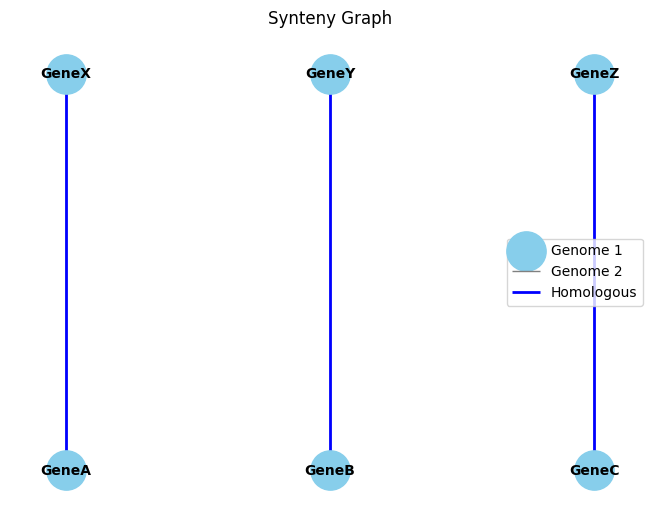

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the gene order in each genome
genome1_genes = ['GeneA', 'GeneB', 'GeneC']
genome2_genes = ['GeneX', 'GeneY', 'GeneZ']

# Create a synteny graph
G = nx.Graph()

# Add nodes for each gene in both genomes
G.add_nodes_from(genome1_genes, group=1)
G.add_nodes_from(genome2_genes, group=2)

# Add edges to represent homologous relationships
homologous_pairs = [('GeneA', 'GeneX'), ('GeneB', 'GeneY'), ('GeneC', 'GeneZ')]
G.add_edges_from(homologous_pairs)

# Define node positions for better visualization
pos = {'GeneA': (1, 1), 'GeneB': (2, 1), 'GeneC': (3, 1),
       'GeneX': (1, 2), 'GeneY': (2, 2), 'GeneZ': (3, 2)}

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', edge_color='gray')

# Highlight homologous relationships with a different color
edge_colors = ['blue' if G[e[0]][e[1]] else 'gray' for e in G.edges]
nx.draw_networkx_edges(G, pos, edgelist=homologous_pairs, edge_color='blue', width=2)

# Add labels and legend
plt.title("Synteny Graph")
plt.legend(['Genome 1', 'Genome 2', 'Homologous'])

# Show the graph
plt.show()

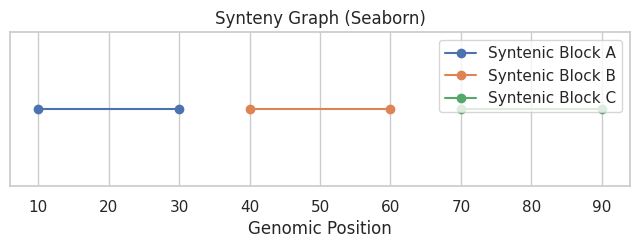

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_syntenic_graph_seaborn():
    # Example synteny data
    data = {
        'start': [10, 40, 70],
        'end': [30, 60, 90],
        'block_id': ['A', 'B', 'C']
    }

    sns.set(style="whitegrid")
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    for i in range(len(data['start'])):
        ax.plot([data['start'][i], data['end'][i]], [0, 0], marker='o', label=f"Syntenic Block {data['block_id'][i]}")

    ax.set_title("Synteny Graph (Seaborn)")
    ax.set_xlabel("Genomic Position")
    ax.set_yticks([])
    ax.legend()

    plt.show()

if __name__ == "__main__":
    draw_syntenic_graph_seaborn()



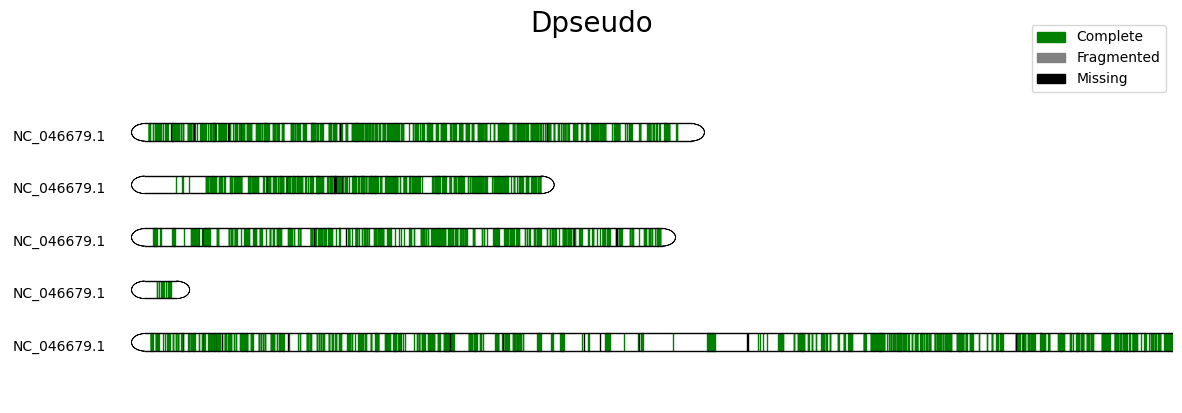

           Chr  Start       End  species  size  color
0  NC_046679.1      1  32422566  Dpseudo    12  25252
1  NC_046680.1      1  23510042  Dpseudo    12  25252
2  NC_046681.1      1  30706867  Dpseudo    12  25252
3  NC_046682.1      1   1881070  Dpseudo    12  25252
4  NC_046683.1      1  68158638  Dpseudo    12  25252


In [3]:
import os
import matplotlib
import pandas as pd
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# Load the busco fulltable.tsv file
def load_busco_fulltable(busco_fulltable: str) -> pd.DataFrame:

    full_table = pd.DataFrame()
    busco_table = pd.read_csv(busco_fulltable, skiprows=2, sep='\t')

    full_table['busco_id'] = busco_table['# Busco id']
    full_table['status'] = busco_table['Status']
    full_table['sequence'] = busco_table['Sequence']
    full_table['gene_start'] = busco_table['Gene Start']
    full_table['gene_end'] = busco_table['Gene End']
    full_table['strand'] = busco_table['Strand']
    full_table['score'] = busco_table['Score']
    full_table['length'] = busco_table['Length']


    try:
        full_table['ortho_db_url'] = busco_table['OrthoDB url']
    except:
        full_table['ortho_db_url'] = None
    
    try:
        full_table['description'] = busco_table['Description']
    except:
        full_table['description'] = None

    return full_table

def get_color(item) -> str:

    if item['status'] == 'Complete':
        return 'green'
    elif item['status'] == 'Partial':
        return 'gray'
    else:
        return 'black'


def karyoplot(karyotype_file: str, busco_fulltable: str, output_file: str, title: str) -> None:

    karyotype = pd.read_csv(karyotype_file, sep="\t")
    fulltable = load_busco_fulltable(busco_fulltable=busco_fulltable)

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.axis('off')

    DIM = 20

    # Set the limits of the plot
    X_lim = DIM * len(max(karyotype['Chr'], key=len))
    Y_lim = DIM * len(karyotype) + 10

    ax.set_xlim([0, X_lim])
    ax.set_ylim([0, Y_lim])

    # Insert the plot title
    ax.text(X_lim / 2, Y_lim - 4, title, fontsize=20, ha='center')

    chr_max_len = max(karyotype['Chr'], key=len)

    # Plot the karyotypes
    for index, row in karyotype.iterrows():
        
        # Get the data of the karyotype
        chr_dim     = row['End']

        # Define the coordinates for the rectangle
        x_start = DIM + len(chr_max_len) * 0.5
        x_end   = x_start + DIM * 0.3 * (chr_dim / karyotype['End'].min())
        y_start = (len(karyotype) - index) * DIM * 0.75
        y_end   = y_start + (DIM * 0.25)

        ax.text(0.5, y_start, chr_max_len)

        #plot the caryotypes
        for i, item in fulltable[fulltable['sequence'] == row.Chr].iterrows():
            re = Rectangle((x_start + (item['gene_start'] * (x_end-x_start)) / chr_dim, y_start), 
                            (x_start + (item['gene_end'] * (x_end-x_start)) / chr_dim) - (x_start + (item['gene_start'] * (x_end-x_start)) / chr_dim), 
                            y_end - y_start, color = get_color(item), linewidth=1)
            ax.add_patch(re)

        center_y = (y_end + y_start)/2.0 - 0.17
        radius = (y_end - y_start)/2.0
        theta1 = -90.0
        theta2 = 90.0
        w1 = Wedge((x_start, center_y), radius, theta2, theta1, width=0.00001, facecolor='white', edgecolor='black', linewidth=0.6)
        w2 = Wedge((x_end, center_y),   radius, theta1, theta2, width=0.00001, facecolor='white', edgecolor='black', linewidth=0.6)
        ax.add_patch(w1)
        ax.add_patch(w2)
        ax.plot([x_start, x_end], [y_start, y_start], ls='-', color='black', linewidth=1)
        ax.plot([x_start, x_end], [y_end, y_end], ls='-', color='black', linewidth=1)

    # Write the legend
    plt.legend(handles=[Rectangle((0,0),1,1, color='green'), 
                        Rectangle((0,0),1,1, color='gray'), 
                        Rectangle((0,0),1,1, color='black')],
                        labels=['Complete', 'Fragmented', 'Missing'], loc='upper right')
    plt.show()

    print(karyotype)

karyoplot("./Dpseudo_karyotype.txt", "./Dpseudo_full_table.tsv", "test.png", "Dpseudo")

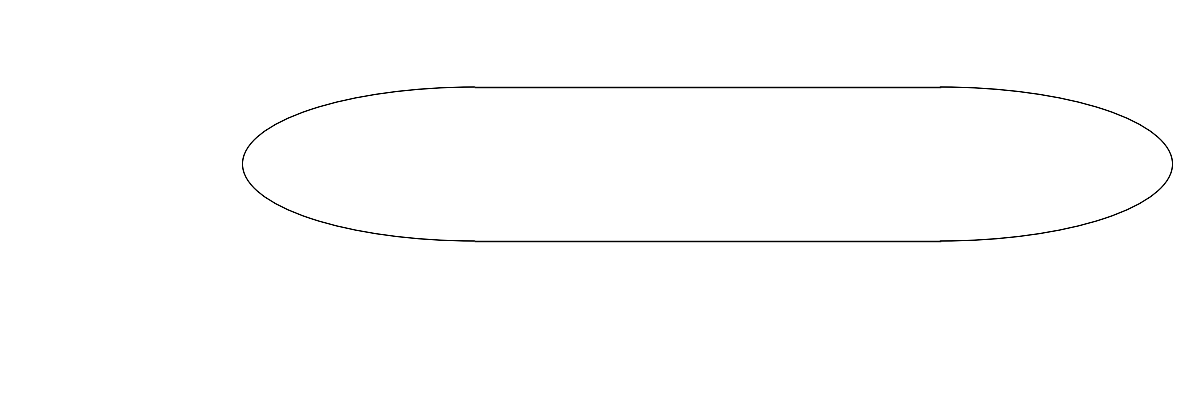

In [336]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.axis('off')

x_start = 2
x_end   = 4
y_start = 2
y_end   = 4

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

center_y = (y_end + y_start)/2.0
radius = (y_end - y_start)/2.0
theta1 = -90.0
theta2 = 90.0

w1 = Wedge((x_start, center_y), radius, theta2, theta1, width=0.00001, facecolor='white', edgecolor='black', linewidth=0.6)
w2 = Wedge((x_end, center_y),   radius, theta1, theta2, width=0.00001, facecolor='white', edgecolor='black', linewidth=0.6)
ax.add_patch(w1)
ax.add_patch(w2)
ax.plot([x_start, x_end], [y_start, y_start], ls='-', color='black', linewidth=1)
ax.plot([x_start, x_end], [y_end, y_end], ls='-', color='black', linewidth=1)



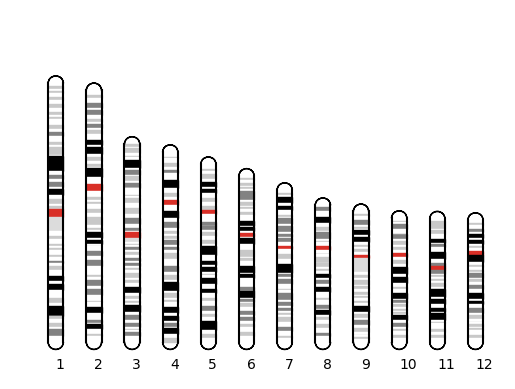

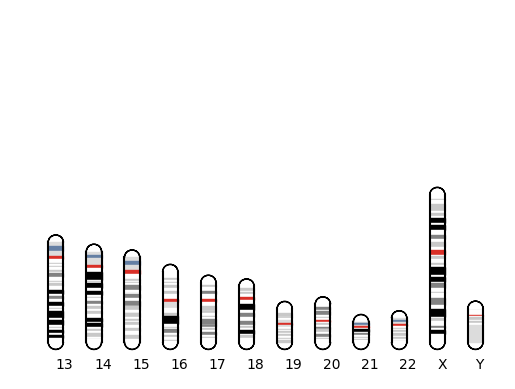

In [315]:
import os
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

def karyoplot(karyo_filename, metadata={}, part=1):
	'''
	To create a karyo_filename go to: http://genome.ucsc.edu/cgi-bin/hgTables 
	group: Mapping and Sequencing
	track: Chromosome Band 
	An example of an output (hg19, Human) is here: http://pastebin.com/6nBX6sdE 
	The script will plot dots next to loci defined in metadata as:
	metadata = {
		'1' : [2300000, 125000000, 249250621],
	}
	'''


	karyo_dict={}
	with open(karyo_filename) as karyo_f:
		lines = [x.replace(os.linesep, '').split() for x in karyo_f.readlines()]

		for chromosome in [str(x) for x in range(1,23)] + ['X', 'Y']:
			karyo_dict[chromosome] = [[y[0], int(y[1]), int(y[2]), y[3], y[4]] for y in [x for x in lines if x[0] == 'chr' + chromosome]]

	fig, ax = plt.subplots()

	DIM = 1.0

	ax.set_xlim([0.0, DIM * (1.3)])
	ax.set_ylim([0.0, DIM])

	def get_chromosome_length(chromosome):
		chromosome_start = float(min([x[1] for x in karyo_dict[chromosome]]))
		chromosome_end = float(max(x[2] for x in karyo_dict[chromosome]))
		chromosome_length = chromosome_end - chromosome_start

		return chromosome_length

	def plot_chromosome(chromosome, order):

		chromosome_length = get_chromosome_length(chromosome)
		chromosome_length_1 = get_chromosome_length('1')

		x_start = order * DIM * 0.1 
		x_end = x_start + (DIM * 0.04)
		y_start = DIM * 0.8 * (chromosome_length/chromosome_length_1)
		y_end = DIM * 0.1


		# We use the same colors as: http://circos.ca/tutorials/lessons/2d_tracks/connectors/configuration 
		colors = {
			'gpos100' : (0/255.0,0/255.0,0/255.0),
			'gpos'    : (0/255.0,0/255.0,0/255.0),
			'gpos75'  : (130/255.0,130/255.0,130/255.0),
			'gpos66'  : (160/255.0,160/255.0,160/255.0),
			'gpos50'  : (200/255.0,200/255.0,200/255.0),
			'gpos33'  : (210/255.0,210/255.0,210/255.0),
			'gpos25'  : (200/255.0,200/255.0,200/255.0),
			'gvar'    : (220/255.0,220/255.0,220/255.0),
			'gneg'    : (255/255.0,255/255.0,255/255.0),
			'acen'    : (217/255.0,47/255.0,39/255.0),
			'stalk'   : (100/255.0,127/255.0,164/255.0),
		}

		for index, piece in enumerate(karyo_dict[chromosome]):

			current_height = piece[2] - piece[1]
			current_height_sc = ((y_end - y_start) / chromosome_length) * current_height
			if index == 0:
				y_previous = y_start

			y_next = y_previous + current_height_sc

			color = colors[piece[4]]

			#plot the caryotypes
			r = Rectangle((x_start, y_previous), x_end-x_start, current_height_sc, color = color)
			ax.add_patch(r)

			y_previous = y_next

		#Plot semicircles at the beginning and end of the chromosomes
		center_x = x_start + (x_end-x_start)/2.0
		radius = (x_end-x_start)/2.0
		theta1 = 0.0
		theta2 = 180.0
		w1 = Wedge((center_x, y_start), radius, theta1, theta2, width=0.00001, facecolor='white', edgecolor='black')
		w2 = Wedge((center_x, y_end), radius, theta2, theta1, width=0.00001, facecolor='white', edgecolor='black')
		ax.add_patch(w1)
		ax.add_patch(w2)
		ax.plot([x_start, x_start], [y_start, y_end], ls='-', color='black')
		ax.plot([x_end, x_end], [y_start, y_end], ls='-', color='black')

		#Plot metadata
		if chromosome in metadata:
			for md in metadata[chromosome]:
				ax.plot([x_end + (DIM*0.015)], [y_start + (y_end-y_start) * (md/chromosome_length)], '.', color='black')

		ax.text(center_x, y_end - (DIM * 0.07), chromosome)

	if part==1:
		plot_chromosome('1', 1)
		plot_chromosome('2', 2)
		plot_chromosome('3', 3)
		plot_chromosome('4', 4)
		plot_chromosome('5', 5)
		plot_chromosome('6', 6)
		plot_chromosome('7', 7)
		plot_chromosome('8', 8)
		plot_chromosome('9', 9)
		plot_chromosome('10', 10)
		plot_chromosome('11', 11)
		plot_chromosome('12', 12)


	elif part==2:
		plot_chromosome('13', 1)
		plot_chromosome('14', 2)
		plot_chromosome('15', 3)
		plot_chromosome('16', 4)
		plot_chromosome('17', 5)
		plot_chromosome('18', 6)
		plot_chromosome('19', 7)
		plot_chromosome('20', 8)
		plot_chromosome('21', 9)
		plot_chromosome('22', 10)
		plot_chromosome('X', 11)
		plot_chromosome('Y', 12)

	else:
		raise Exception('plot argument should be either "1" or "2"')

	plt.axis('off')
	plt.show()

if __name__ == '__main__':
	import urllib
	fn = 'karyotype_hg19.txt'

	karyoplot(fn, part=1)
	karyoplot(fn, part=2)